In [10]:
import numpy as np
import pandas as pd

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# sns.set_style("ticks")
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42

In [ ]:
# Content of data frame:
# 'session_id': Unique ID of the recording session. The trajectory data will be the same for all cells that have the same session_id
# It consists of the animal_id (M0, M1...), date, and session type (open field)
# 'cluster_id': Unique ID of cell *within* the session. (session_id + cluster_id together are a unique ID for a cell in the entire data set)
# 'position_x': Position of animal (x coordinate) when the cell fired. Corresponds to position_y, hd and firing_times
# 'position_y': Position of animal (y coordinate) when the cell fired.
# 'hd': Head direction of animal when the cell fired.
# 'firing_maps': Firing rate map of cell.
# 'firing_times': Times when cell fired.
# 'trajectory_hd': Head direction from the trajectory of the animal.
# 'trajectory_x': x coordinate of the trajectory of the animal.
# 'trajectory_y': y coordinate of the trajectory of the animal.
# 'trajectory_times': sampling times of the trajectory of the animal. (~30 samples / sec frame rate).

In [2]:
fp_data = '/mnt/807ADEB67ADEA7E4/GerleiMice/SORTED_CLUSTERS/sorted_clusters.pkl'

In [3]:
data = pd.read_pickle(fp_data)

In [25]:
data.head()

,session_id,cluster_id,position_x,position_y,hd,firing_maps,firing_times,trajectory_hd,trajectory_x,trajectory_y,trajectory_times
11,M0_2017-11-15_14-52-15_of,12,"[1.7178965909090904, 1.1862602272727274, 1.186...","[7.2429774999999985, 3.7494206818181817, 3.749...","[156.66475083349192, 137.38600140667376, 137.3...","[[3.374810282884154, 3.3894260264610554, 3.394...","[160.0, 11669.0, 12143.0, 15903.0, 19129.0, 25...",0 156.664751 1 148.394416 2 ...,0 1.717897 1 1.804099 2 ...,0 7.242977 1 6.787384 2 ...,0 0.036803 1 0.101238 2 ...
5,M0_2017-11-16_14-45-03_of,6,"[nan, 5.953374318181819, 5.953374318181819, 5....","[nan, 3.362840568181818, 3.362840568181818, 3....","[nan, 4.399812464254153, 4.399812464254153, 9....","[[6.799888229247266, 6.926669133283486, 7.2069...","[649.0, 3669.0, 4745.0, 7432.0, 7936.0, 8293.0...",0 NaN 1 NaN 2 ...,0 NaN 1 NaN 2 ...,0 NaN 1 NaN 2 ...,0 1848.274306 1 1848.399055 2 ...
3,M0_2017-11-21_15-52-53_of,4,"[nan, nan, 2.939026590909091, 2.93902659090909...","[nan, nan, 1.3312582954545455, 1.3312582954545...","[nan, nan, 49.173055862756854, 49.173055862756...","[[35.05999286926326, 35.178578028661974, 35.37...","[32.0, 2633.0, 4636.0, 4894.0, 7862.0, 8456.0,...",0 NaN 1 NaN 2 ...,0 NaN 1 NaN 2 ...,0 NaN 1 NaN 2 ...,0 45.721145 1 45.844690 2 ...
6,M0_2017-11-21_15-52-53_of,7,"[nan, 2.9304436363636355, 2.904357272727272, 3...","[nan, 3.432962954545455, 5.257890568181819, 7....","[nan, 23.344409644281058, 2.2105493731707204, ...","[[9.333846397378275, 9.36584558223673, 9.35991...","[1910.0, 9992.0, 13581.0, 17787.0, 18183.0, 21...",0 NaN 1 NaN 2 ...,0 NaN 1 NaN 2 ...,0 NaN 1 NaN 2 ...,0 45.721145 1 45.844690 2 ...
9,M0_2017-11-23_14-09-12_of,10,"[81.42976386363637, 81.42976386363637, 81.0735...","[22.519857954545454, 22.519857954545454, 21.69...","[111.29903165109985, 111.29903165109985, 109.2...","[[32.399667803335284, 26.12261897224064, 19.60...","[209.0, 851.0, 1351.0, 1658.0, 3480.0, 4106.0,...",0 111.299032 1 109.211876 2 ...,0 81.429764 1 81.073582 2 ...,0 22.519858 1 21.693060 2 ...,0 2163.646138 1 2163.780423 2 ...


In [26]:
data.iloc[4,5].shape

(42, 40)

<IPython.core.display.Javascript object>


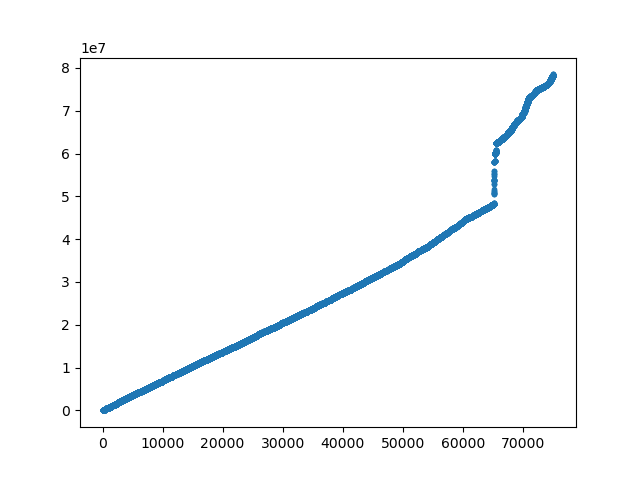

In [23]:
plt.plot(data.iloc[4,6], '.')
plt.show()

<IPython.core.display.Javascript object>


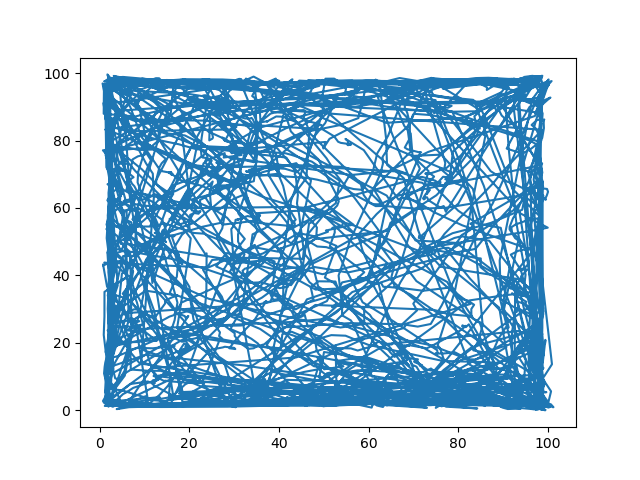

In [18]:
plt.plot(data.iloc[0,2], data.iloc[0,3])
plt.show()

<IPython.core.display.Javascript object>


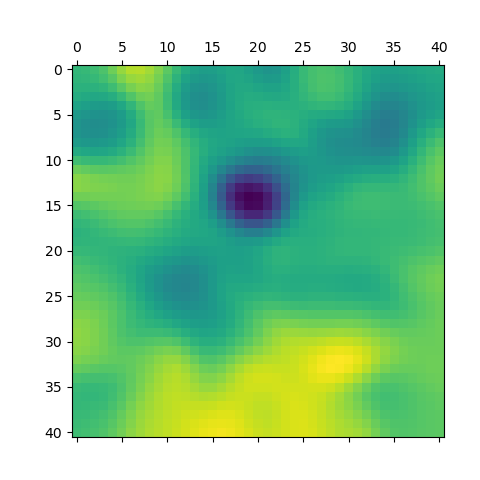

In [30]:
plt.matshow(data.iloc[10,5], aspect='auto')
plt.show()

In [31]:
data.shape

(375, 11)

In [33]:
all_rm = np.array(data.iloc[:,5])

In [37]:
[np.pad(x, ) for x in all_rm]

[(41, 41),
 (42, 41),
 (41, 40),
 (41, 40),
 (42, 40),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (41, 41),
 (41, 41),
 (41, 41),
 (41, 41),
 (41, 41),
 (41, 41),
 (41, 41),
 (41, 41),
 (41, 41),
 (41, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 40),
 (42, 40),
 (42, 41),
 (42, 40),
 (42, 40),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (41, 40),
 (41, 40),
 (41, 40),
 (41, 40),
 (41, 40),
 (41, 40),
 (41, 40),
 (41, 40),
 (41, 40),
 (41, 40),
 (41, 40),
 (41, 40),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 40),
 (41, 41),
 (42, 41),
 (42, 41),
 (41, 41),
 (41, 41),
 (41, 41),
 (41, 41),
 (41, 41),
 (41, 41),
 (41, 41),
 (41, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),
 (42, 41),

<IPython.core.display.Javascript object>


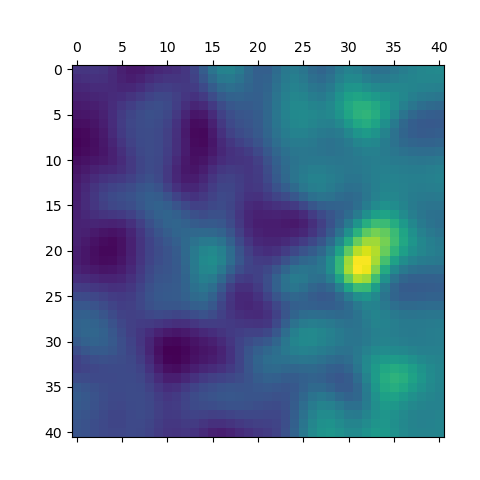

In [35]:
plt.matshow(all_rm[0], aspect='auto')
plt.show()